In [136]:
from sklearn.metrics import roc_curve, auc
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [138]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)
df_shrink = df[["number_of_seasons","number_of_episodes","vote_count","vote_average","popularity"]]

In [139]:
X = df.drop(columns=['popularity', 'overview'], axis=1)
X = X.dropna(axis=1)
y = df['popularity']

In [140]:
X.astype(object)

,id,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,adult,in_production,type,status,episode_run_time
0,1399,8,73,en,21857,8.442,False,False,Scripted,Ended,0
1,71446,3,41,es,17836,8.257,False,False,Scripted,Ended,70
2,66732,4,34,en,16161,8.624,False,True,Scripted,Returning Series,0
3,1402,11,177,en,15432,8.121,False,False,Scripted,Ended,42
4,63174,6,93,en,13870,8.486,False,False,Scripted,Ended,45
...,...,...,...,...,...,...,...,...,...,...,...
168634,239099,1,1,zh,0,0.0,False,True,Scripted,Returning Series,0
168635,241205,1,1,es,0,0.0,False,False,Scripted,Ended,0
168636,240696,1,1,bn,0,0.0,False,True,Scripted,Returning Series,0
168637,240697,1,1,en,0,0.0,False,True,Scripted,Returning Series,0


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=123)

In [131]:
X_train.shape

(33718, 4)

In [132]:
# Before training on the Gradient Boosted DT, I first train on a simple decision tree

def train_test_DT(X_train, X_test, y_train, y_test, leaf, depth, crit='squared_error'):
    model = DecisionTreeRegressor(min_samples_leaf=leaf, max_depth=depth, criterion=crit)
    model.fit(X_train, y_train)
    class_label_predictions = model.predict(X_test)
    #mse_score = mean_squared_error(y_test, class_label_predictions)
    #return mse_score
    return r2_score(class_label_predictions, y_test)

In [ ]:
max_depth_range = [2,4,8,16,32,64,128]

acc = []

for md in max_depth_range:
    score = train_test_DT(X_train, X_test, y_train, y_test, 1, md)
    print('Max Depth=' + str(md) + ', r2 score: ' + str(score))
    acc.append(float(score))

Max Depth=2, accuracy score: -5.879492513192333
Max Depth=4, accuracy score: -2.067245911925701
Max Depth=8, accuracy score: -1.1002430695554466
Max Depth=16, accuracy score: -0.38411958634013565
Max Depth=32, accuracy score: -0.3718306950508612
Max Depth=64, accuracy score: -0.33052784817870196
Max Depth=128, accuracy score: -0.2813673820693463
Max Depth=1024, accuracy score: -0.21860834389500328


In [134]:
# Now, will try data on a GBDT
regressor = GradientBoostingRegressor(
    n_estimators=50, 
    learning_rate=0.3, 
    max_depth=2
)
regressor.fit(X_train, y_train)
regressor_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, regressor_pred)
print(f"Mean Squared Error (MSE): {mse:.3f}")

Mean Squared Error (MSE): 0.000


In [ ]:
# GBDT Classifier with a condensed data set
X = df_shrink.drop("popularity", axis=1)
y = pd.cut(df_shrink["popularity"], bins=3, labels=[0, 1, 2]) 

X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)

def GradientBoostingClassifierModel(X_train, y_train, X_test, n_estimators, max_depth):
   model = GradientBoostingClassifier(n_estimators = n_estimators, max_depth = max_depth)
   model.fit(X_train, y_train)
   model_preds = model.predict_proba(X_test)
   return model_preds[:, -1]


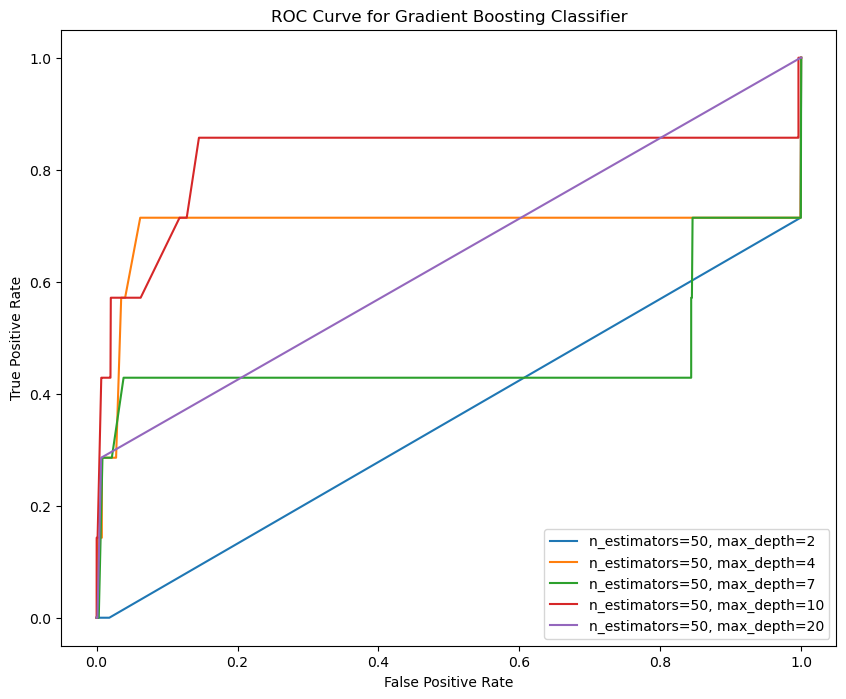

In [ ]:
n_estimators = [50] 
max_depths = [2, 4, 7, 10, 20] 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for n_est in n_estimators:
    for depth in max_depths:
        y_pred_proba = GradientBoostingClassifierModel(X_train, y_train, X_test, n_est, depth)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_x = auc(fpr, tpr)
        print("AUC of the GBDT model with a max depth of {} is {:.3f}".format(depth, auc))
        ax.plot(fpr, tpr, label=f"n_estimators={n_est}, max_depth={depth}")

ax.set_title("ROC Curve for Gradient Boosting Classifier")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="best")
plt.show()